# Helper Scripts

## Libraries Used

In [1]:
import cv2
import re
import matplotlib.pyplot as plt
import numpy as np
import os

## Unusual Rotations Count

In [1]:
import os
import re

def return_extracted(line):
    """Extract numeric value from an XMP metadata line."""
    value = line.split('=')[1]
    return float(re.sub(r'[^\d.-]', '', value))

def extract_line_from_index(document, index):
    """Extract a specific metadata line from XMP content."""
    if index == -1:  
        return None
    
    start = document.rfind('\n', 0, index)
    if start == -1:
        start = 0
    else:
        start += 1

    end = document.find('\n', index)
    if end == -1:
        end = len(document)

    return document[start:end]

def extract_xmp_data(image_path):
    """Extract XMP metadata from an image."""
    with open(image_path, 'rb') as f:
        data = f.read()
    
    xmp_start = data.find(b'<x:xmpmeta')
    xmp_end = data.find(b'</x:xmpmeta>')
    
    if xmp_start != -1 and xmp_end != -1:
        xmp_end += len(b'</x:xmpmeta>')
        try:
            xmp_str = data[xmp_start:xmp_end].decode('utf-8', errors='replace')
            return xmp_str
        except Exception as e:
            print(f"[ERROR] Decoding XMP metadata from {image_path}: {e}")
            return None
    else:
        return None

def count_unusual_rotations(folder_path):
    """Count images that require unusual rotations (outside standard yaw ranges)."""
    if not os.path.exists(folder_path):
        print("[ERROR] Folder does not exist.")
        return

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.dng'))]
    
    if not image_files:
        print("[ERROR] No image files found in the folder.")
        return
    
    unusual_count = 0
    total_images = len(image_files)

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        xmp = extract_xmp_data(image_path)

        if xmp:
            try:
                index = xmp.find("drone-dji:GimbalYawDegree")
                yaw_line = extract_line_from_index(xmp, index)
                yaw = return_extracted(yaw_line)

                # **Exclude images with yaw values in the standard range**
                if not (
                    -5 <= yaw <= 5 or  # Close to 0° (Horizontal)
                    85 <= abs(yaw) <= 95 or  # Close to 90°
                    175 <= abs(yaw) <= 185 or  # Close to 180°
                    265 <= abs(yaw) <= 275  # Close to 270°
                ):
                    print(f"Unusual rotation for yaw = {yaw}")
                    unusual_count += 1

            except Exception as e:
                print(f"[ERROR] Failed to extract Yaw for {image_path}: {e}")

    print(f"📂 Total Images Processed: {total_images}")
    print(f"⚠ Unusual Rotations Found: {unusual_count}")

# 🔹 Define input folder
input_folder = "Data"

# 🔥 Run the script
count_unusual_rotations(input_folder)


Unusual rotation for yaw = -50.8
Unusual rotation for yaw = -50.8
Unusual rotation for yaw = -128.0
Unusual rotation for yaw = -128.0
Unusual rotation for yaw = -128.3
Unusual rotation for yaw = -128.3
Unusual rotation for yaw = -126.9
Unusual rotation for yaw = -126.9
Unusual rotation for yaw = -32.2
Unusual rotation for yaw = -32.3
Unusual rotation for yaw = -32.3
Unusual rotation for yaw = 54.3
Unusual rotation for yaw = 44.4
Unusual rotation for yaw = 135.2
Unusual rotation for yaw = 48.0
Unusual rotation for yaw = 5.3
Unusual rotation for yaw = 5.4
Unusual rotation for yaw = 5.6
Unusual rotation for yaw = 5.6
Unusual rotation for yaw = 5.6
Unusual rotation for yaw = 5.6
Unusual rotation for yaw = 5.7
Unusual rotation for yaw = 5.8
Unusual rotation for yaw = 5.2
Unusual rotation for yaw = 5.1
Unusual rotation for yaw = 49.6
Unusual rotation for yaw = 5.2
Unusual rotation for yaw = 5.1
Unusual rotation for yaw = 5.3
Unusual rotation for yaw = 5.3
Unusual rotation for yaw = 5.4
Unusu

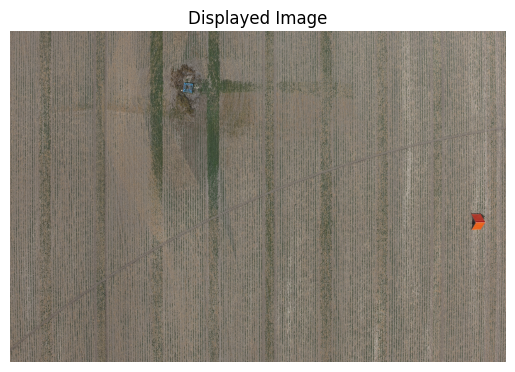

In [19]:
img = cv2.imread(image_path)

# Check if the image was successfully loaded
if img is None:
    print("Error: Image not found or unable to load.")
else:
    # Convert the image from BGR (OpenCV default) to RGB for proper display with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axis
    plt.title("Displayed Image")
    plt.show()


## Sensor Model Distortion (Radial):

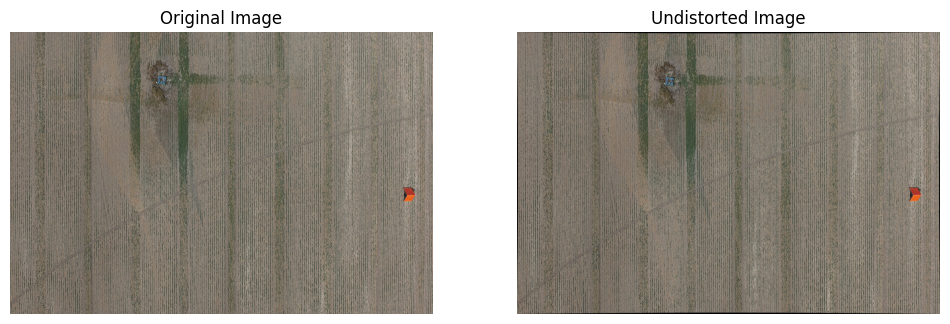

In [26]:
def undistort_image(image, camera_matrix, dist_coeffs):
    """
    Corrects radial and tangential distortions in the image using camera calibration data.
    """
    h, w = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    return undistorted

# Define the camera matrix and distortion coefficients.
camera_matrix = np.array([
    [7954.6,    0, 4096],
    [    0, 7962.5, 2730],
    [    0,    0,    1]
], dtype=np.float32)

dist_coeffs = np.array([-0.05, 0.03, 0, 0, 0], dtype=np.float32)
# Alternatively, if you want to assume zero distortion, use:
# dist_coeffs = np.zeros((5, 1), dtype=np.float32)

image = cv2.imread(image_path)

if image is None:
    print("Error: Unable to load image from", image_path)
else:
    # Undistort the image
    undistorted_image = undistort_image(image, camera_matrix, dist_coeffs)

    # Convert images from BGR (OpenCV default) to RGB for proper display with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undistorted_rgb = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB)

    # Display the original and undistorted images side by side using matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(undistorted_rgb)
    plt.title("Undistorted Image")
    plt.axis("off")

    plt.show()


## Saving the output

In [ ]:
save_dir = "orthorectified_images"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = os.path.join(save_dir, "undistorted_image.jpg")

cv2.imwrite(save_path, undistorted_image)
print("Undistorted image saved to", save_path)

## Read EXIF

In [13]:
import os
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

def extract_exif_metadata(image_path):
    """Extracts EXIF metadata from an image file."""
    try:
        img = Image.open(image_path)
        exif_data = img._getexif()

        if not exif_data:
            print(f"[WARNING] No EXIF metadata found in {image_path}")
            return None

        exif_dict = {}
        for tag_id, value in exif_data.items():
            tag_name = TAGS.get(tag_id, tag_id)
            exif_dict[tag_name] = value

        return exif_dict
    except Exception as e:
        print(f"[ERROR] Failed to extract EXIF metadata from {image_path}: {e}")
        return None

def process_folder(folder_path, output_folder):
    """Processes all images in a folder and extracts EXIF metadata."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.tiff', '.png'))]

    if not image_files:
        print("[ERROR] No image files found in the folder.")
        return

    print(f"📂 Processing {len(image_files)} images in folder: {folder_path}\n")

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        exif_metadata = extract_exif_metadata(image_path)

        if exif_metadata:
            output_filename = os.path.join(output_folder, f"{os.path.splitext(image_file)[0]}_exif.txt")
            with open(output_filename, "w", encoding="utf-8") as f:
                for tag, value in exif_metadata.items():
                    f.write(f"{tag}: {value}\n")
            print(f"✅ EXIF metadata saved: {output_filename}")

# 🔹 Define input and output folders
input_folder = "88_89"  # Change to your folder path
output_folder = "check"  # Folder where extracted EXIF data will be saved

# 🔥 Run the script
process_folder(input_folder, output_folder)


📂 Processing 2 images in folder: 88_89

[WARNING] No EXIF metadata found in 88_89\DJI_20240614150116_0088_HA-waypoint16-80m_ep1.jpg
[WARNING] No EXIF metadata found in 88_89\DJI_20240614150119_0089_HA-waypoint17-80m_ep1.jpg


## Reading PRY from XMP

In [5]:
import os
import re
import xml.etree.ElementTree as ET

def return_extracted(value):
    """Extract numeric values from an XMP metadata field."""
    return float(re.sub(r'[^\d.-]', '', value))

def extract_xmp_data(image_path):
    """Extracts and displays Gimbal PRY values from an image's XMP metadata."""
    with open(image_path, 'rb') as f:
        data = f.read()

    xmp_start = data.find(b'<x:xmpmeta')
    xmp_end = data.find(b'</x:xmpmeta>')

    if xmp_start != -1 and xmp_end != -1:
        xmp_end += len(b'</x:xmpmeta>')
        try:
            xmp_str = data[xmp_start:xmp_end].decode('utf-8', errors='replace')

            # Parse XML structure
            root = ET.fromstring(xmp_str)

            # Initialize metadata storage
            gimbal_pitch, gimbal_roll, gimbal_yaw = None, None, None

            # Extract Gimbal PRY values
            for elem in root.iter():
                for key, value in elem.attrib.items():
                    if "GimbalPitchDegree" in key:
                        gimbal_pitch = return_extracted(value)
                    elif "GimbalRollDegree" in key:
                        gimbal_roll = return_extracted(value)
                    elif "GimbalYawDegree" in key:
                        gimbal_yaw = return_extracted(value)

            # Display extracted data
            print(f"\n📜 **XMP Metadata for** `{os.path.basename(image_path)}`:")
            print("-" * 60)
            if gimbal_pitch is not None and gimbal_roll is not None and gimbal_yaw is not None:
                print(f"🔹 **Gimbal Pitch**: {gimbal_pitch}°")
                print(f"🔹 **Gimbal Roll** : {gimbal_roll}°")
                print(f"🔹 **Gimbal Yaw**  : {gimbal_yaw}°")
            else:
                print("⚠️ Gimbal PRY values not found in metadata.")
            print("-" * 60)

        except Exception as e:
            print(f"[ERROR] Decoding XMP metadata from {image_path}: {e}")
    else:
        print(f"[❌] No XMP metadata found in `{os.path.basename(image_path)}`")

def process_folder(folder_path):
    """Processes all images in a folder and extracts Gimbal PRY values from XMP metadata."""
    if not os.path.exists(folder_path):
        print("[ERROR] Folder does not exist.")
        return

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.dng'))]

    if not image_files:
        print("[ERROR] No image files found in the folder.")
        return

    print(f"\n📂 **Processing {len(image_files)} images in folder:** `{folder_path}`\n")

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        extract_xmp_data(image_path)

# 🔹 Define input folder path
input_folder = "88_89"  # Change this to your actual folder path

# 🔥 Run the script
process_folder(input_folder)



📂 **Processing 2 images in folder:** `88_89`


📜 **XMP Metadata for** `DJI_20240614150116_0088_HA-waypoint16-80m.JPG`:
------------------------------------------------------------
🔹 **Gimbal Pitch**: -89.9°
🔹 **Gimbal Roll** : 180.0°
🔹 **Gimbal Yaw**  : 179.1°
------------------------------------------------------------

📜 **XMP Metadata for** `DJI_20240614150119_0089_HA-waypoint17-80m.JPG`:
------------------------------------------------------------
🔹 **Gimbal Pitch**: -89.9°
🔹 **Gimbal Roll** : 180.0°
🔹 **Gimbal Yaw**  : 179.3°
------------------------------------------------------------


## Reading XMP

In [2]:
import os
import xml.etree.ElementTree as ET

def extract_xmp_data(image_path):
    """Extracts and prints formatted XMP metadata from an image in a clean way."""
    with open(image_path, 'rb') as f:
        data = f.read()

    xmp_start = data.find(b'<x:xmpmeta')
    xmp_end = data.find(b'</x:xmpmeta>')

    if xmp_start != -1 and xmp_end != -1:
        xmp_end += len(b'</x:xmpmeta>')
        try:
            xmp_str = data[xmp_start:xmp_end].decode('utf-8', errors='replace')

            # Parse XML structure
            root = ET.fromstring(xmp_str)
            metadata_dict = {}
            
            for elem in root.iter():
                for key, value in elem.attrib.items():
                    metadata_dict[key] = value

            # Pretty Print Metadata
            print(f"\n📜 **XMP Metadata for** `{os.path.basename(image_path)}`:\n{'-'*60}")
            for key, value in metadata_dict.items():
                print(f"🔹 **{key}**: {value}")

            print("-"*60)

        except Exception as e:
            print(f"[ERROR] Decoding XMP metadata from {image_path}: {e}")
    else:
        print(f"[❌] No XMP metadata found in `{os.path.basename(image_path)}`")

def process_folder(folder_path):
    """Processes all images in a folder and extracts XMP metadata."""
    if not os.path.exists(folder_path):
        print("[ERROR] Folder does not exist.")
        return

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.dng'))]

    if not image_files:
        print("[ERROR] No image files found in the folder.")
        return

    print(f"\n📂 **Processing {len(image_files)} images in folder:** `{folder_path}`\n")

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        extract_xmp_data(image_path)

# 🔹 Define input folder path
input_folder = "88_89"  # Change this to your actual folder path

# 🔥 Run the script
process_folder(input_folder)



📂 **Processing 2 images in folder:** `88_89`


📜 **XMP Metadata for** `DJI_20240614150116_0088_HA-waypoint16-80m.JPG`:
------------------------------------------------------------
🔹 **{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about**: DJI Meta Data
🔹 **{http://ns.adobe.com/xap/1.0/}ModifyDate**: 2024-06-14 15:01:16
🔹 **{http://ns.adobe.com/xap/1.0/}CreateDate**: 2024-06-14 15:01:16
🔹 **{http://ns.adobe.com/tiff/1.0/}Make**: DJI
🔹 **{http://ns.adobe.com/tiff/1.0/}Model**: ZenmuseP1
🔹 **{http://purl.org/dc/elements/1.1/}format**: image/jpg
🔹 **{http://www.dji.com/drone-dji/1.0/}Version**: 1.4
🔹 **{http://www.dji.com/drone-dji/1.0/}GpsStatus**: Normal
🔹 **{http://www.dji.com/drone-dji/1.0/}AltitudeType**: RtkAlt
🔹 **{http://www.dji.com/drone-dji/1.0/}GpsLatitude**: +50.309881351
🔹 **{http://www.dji.com/drone-dji/1.0/}GpsLongitude**: -112.014015325
🔹 **{http://www.dji.com/drone-dji/1.0/}AbsoluteAltitude**: +841.176
🔹 **{http://www.dji.com/drone-dji/1.0/}RelativeAltitude**: +79.940
🔹 **

## Metadata Preservation Tilt Correction

In [19]:
import cv2
import numpy as np
import os
import re
import math
import piexif
import shutil

def return_extracted(line):
    """Extract numeric value from an XMP metadata line."""
    value = line.split('=')[1]
    return float(re.sub(r'[^\d.-]', '', value))

def extract_line_from_index(document, index):
    """Extract a specific metadata line from XMP content."""
    if index == -1:  
        return None
    
    start = document.rfind('\n', 0, index)
    if start == -1:
        start = 0
    else:
        start += 1

    end = document.find('\n', index)
    if end == -1:
        end = len(document)

    return document[start:end]

def extract_xmp_data(image_path):
    """Extract XMP metadata from an image."""
    with open(image_path, 'rb') as f:
        data = f.read()
    
    xmp_start = data.find(b'<x:xmpmeta')
    xmp_end = data.find(b'</x:xmpmeta>')
    
    if xmp_start != -1 and xmp_end != -1:
        xmp_end += len(b'</x:xmpmeta>')
        try:
            xmp_str = data[xmp_start:xmp_end].decode('utf-8', errors='replace')
            return xmp_str
        except Exception as e:
            print(f"[ERROR] Decoding XMP metadata from {image_path}: {e}")
            return None
    else:
        return None

def extract_exif_data(image_path):
    """Extract EXIF metadata using piexif."""
    try:
        exif_data = piexif.load(image_path)
        return exif_data
    except Exception as e:
        print(f"[ERROR] Failed to extract EXIF from {image_path}: {e}")
        return None

def get_adjusted_rotation_matrix(angle, width, height):
    """Compute rotation matrix and adjust image size to prevent cropping."""
    center = (width / 2, height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    cos = abs(rotation_matrix[0, 0])
    sin = abs(rotation_matrix[0, 1])
    
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))

    rotation_matrix[0, 2] += (new_width / 2) - center[0]
    rotation_matrix[1, 2] += (new_height / 2) - center[1]

    return rotation_matrix, new_width, new_height

def correct_image_perspective(image_path, output_path, summary):
    """Correct an image's perspective using PRY values to get NADIR and preserve metadata."""
    xmp = extract_xmp_data(image_path)
    exif_data = extract_exif_data(image_path)

    if xmp:
        try:
            # Extract PRY values
            index = xmp.find("drone-dji:GimbalPitchDegree")
            pitch_line = extract_line_from_index(xmp, index)
            pitch = return_extracted(pitch_line)

            index = xmp.find("drone-dji:GimbalYawDegree")
            yaw_line = extract_line_from_index(xmp, index)
            yaw = return_extracted(yaw_line)

            index = xmp.find("drone-dji:GimbalRollDegree")
            roll_line = extract_line_from_index(xmp, index)
            roll = return_extracted(roll_line)

            print(f"📸 Processing: {image_path}")
            print(f"   📌 Current PRY → Pitch: {pitch}°, Roll: {roll}°, Yaw: {yaw}°")

            # **✅ If already at NADIR (-90, 0, 0), copy it directly to output**
            if abs(pitch + 90) < 0.5 and abs(roll) < 0.5 and abs(yaw) < 0.5:
                shutil.copy(image_path, os.path.join(output_path, os.path.basename(image_path)))
                summary["nadir_copied"] += 1
                print(f"   ✅ Image already at NADIR. Copied to output folder.\n")
                return  

            # Read the image
            image = cv2.imread(image_path)
            h, w = image.shape[:2]

            # Compute rotation matrices with adjusted output size
            M_yaw, new_w_yaw, new_h_yaw = get_adjusted_rotation_matrix(-yaw, w, h)
            M_roll, new_w_roll, new_h_roll = get_adjusted_rotation_matrix(-roll, new_w_yaw, new_h_yaw)
            M_pitch, new_w_pitch, new_h_pitch = get_adjusted_rotation_matrix(-(pitch + 90), new_w_roll, new_h_roll) 

            # Apply rotations in sequence: Yaw → Roll → Pitch (to achieve NADIR)
            rotated_image = cv2.warpAffine(image, M_yaw, (new_w_yaw, new_h_yaw))
            rotated_image = cv2.warpAffine(rotated_image, M_roll, (new_w_roll, new_h_roll))
            rotated_image = cv2.warpAffine(rotated_image, M_pitch, (new_w_pitch, new_h_pitch))

            # Save the corrected image
            corrected_filename = os.path.join(output_path, os.path.basename(image_path))
            cv2.imwrite(corrected_filename, rotated_image)

            # Restore EXIF metadata
            if exif_data:
                piexif.insert(piexif.dump(exif_data), corrected_filename)

            summary["corrected"] += 1
            print(f"✅ Corrected Image Saved: {corrected_filename} (Metadata Restored)\n")

        except Exception as e:
            summary["errors"] += 1
            print(f"[ERROR] Failed to correct {image_path}: {e}")

def process_folder(folder_path, output_path):
    """Process all images in a folder and correct them to NADIR view, preserving metadata."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.dng'))]
    
    if not image_files:
        print("[ERROR] No image files found in the folder.")
        return

    summary = {"total": len(image_files), "nadir_copied": 0, "corrected": 0, "errors": 0}

    print(f"\n📂 Processing {summary['total']} images in folder: {folder_path}\n")

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        correct_image_perspective(image_path, output_path, summary)

    # **Print Final Summary**
    print("\n📊 **Processing Summary**:")
    print(f"   🔹 **Total Images Processed:** {summary['total']}")
    print(f"   ✅ **Already NADIR (Copied):** {summary['nadir_copied']}")
    print(f"   🔄 **Corrected & Saved:** {summary['corrected']}")
    print(f"   ❌ **Errors Encountered:** {summary['errors']}\n")

# 🔹 Define input and output folders
input_folder = "Data"
output_folder = "main_output"

# 🔥 Run the script
process_folder(input_folder, output_folder)


📂 Processing 8 images in folder: sample

<x:xmpmeta xmlns:x="adobe:ns:meta/">
 <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
  <rdf:Description rdf:about="DJI Meta Data"
    xmlns:tiff="http://ns.adobe.com/tiff/1.0/"
    xmlns:exif="http://ns.adobe.com/exif/1.0/"
    xmlns:xmp="http://ns.adobe.com/xap/1.0/"
    xmlns:xmpMM="http://ns.adobe.com/xap/1.0/mm/"
    xmlns:dc="http://purl.org/dc/elements/1.1/"
    xmlns:crs="http://ns.adobe.com/camera-raw-settings/1.0/"
    xmlns:drone-dji="http://www.dji.com/drone-dji/1.0/"
    xmlns:GPano="http://ns.google.com/photos/1.0/panorama/"
   xmp:ModifyDate="2024-06-14 14:52:23"
   xmp:CreateDate="2024-06-14 14:52:23"
   tiff:Make="DJI"
   tiff:Model="ZenmuseP1"
   dc:format="image/jpg"
   drone-dji:Version="1.4"
   drone-dji:GpsStatus="Normal"
   drone-dji:AltitudeType="RtkAlt"
   drone-dji:GpsLatitude="+50.307243112"
   drone-dji:GpsLongitude="-112.018835873"
   drone-dji:AbsoluteAltitude="+840.260"
   drone-dji:RelativeAltitu

## PRY from XMP

In [1]:
import re
import os

def return_extracted(line):
    """Extract numeric value from an XMP metadata line."""
    value = line.split('=')[1]
    return float(re.sub(r'[^\d.-]', '', value))

def extract_line_from_index(document, index):
    """Extract a specific metadata line from XMP content."""
    if index == -1:  
        return None
    
    start = document.rfind('\n', 0, index)
    if start == -1:
        start = 0
    else:
        start += 1

    end = document.find('\n', index)
    if end == -1:
        end = len(document)

    return document[start:end]

def extract_xmp_data(image_path):
    """Extract XMP metadata from an image."""
    with open(image_path, 'rb') as f:
        data = f.read()
    
    xmp_start = data.find(b'<x:xmpmeta')
    xmp_end = data.find(b'</x:xmpmeta>')
    
    if xmp_start != -1 and xmp_end != -1:
        xmp_end += len(b'</x:xmpmeta>')
        try:
            xmp_str = data[xmp_start:xmp_end].decode('utf-8', errors='replace')
            return xmp_str
        except Exception as e:
            print(f"[ERROR] Decoding XMP metadata from {image_path}: {e}")
            return None
    else:
        return None

def get_pry_from_xmp(image_path):
    """Extract Pitch, Roll, and Yaw values from XMP metadata."""
    xmp = extract_xmp_data(image_path)

    if xmp:
        try:
            # Extract Pitch
            index = xmp.find("drone-dji:GimbalPitchDegree")
            pitch_line = extract_line_from_index(xmp, index)
            pitch = return_extracted(pitch_line)

            # Extract Roll
            index = xmp.find("drone-dji:GimbalRollDegree")
            roll_line = extract_line_from_index(xmp, index)
            roll = return_extracted(roll_line)

            # Extract Yaw
            index = xmp.find("drone-dji:GimbalYawDegree")
            yaw_line = extract_line_from_index(xmp, index)
            yaw = return_extracted(yaw_line)

            return pitch, roll, yaw
        except Exception as e:
            print(f"[ERROR] Failed to extract PRY from {image_path}: {e}")
            return None
    else:
        return None

def process_folder(folder_path):
    """Process all images in a folder and extract PRY values."""
    if not os.path.exists(folder_path):
        print(f"[ERROR] Folder not found: {folder_path}")
        return
    
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.dng'))]

    if not image_files:
        print("[ERROR] No image files found in the folder.")
        return

    print(f"📂 Processing {len(image_files)} images in folder: {folder_path}\n")
    
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        pry_values = get_pry_from_xmp(image_path)

        if pry_values:
            pitch, roll, yaw = pry_values
            print(f"📸 {image_file} → Pitch: {pitch}°, Roll: {roll}°, Yaw: {yaw}°")
        else:
            print(f"⚠ No PRY values found in {image_file}")

# 🔹 Define the input folder
input_folder = "88_89"

# 🔥 Run the script
process_folder(input_folder)


📂 Processing 2 images in folder: 88_89

[ERROR] Failed to extract PRY from 88_89\DJI_20240614150116_0088_HA-waypoint16-80m.JPG: could not convert string to float: ''
⚠ No PRY values found in DJI_20240614150116_0088_HA-waypoint16-80m.JPG
📸 DJI_20240614150119_0089_HA-waypoint17-80m.JPG → Pitch: -89.9°, Roll: 180.0°, Yaw: 179.3°


## Tilt Distortion Along with CSV (Before and After)

In [4]:
import cv2
import numpy as np
import os
import re
import math
import csv

def return_extracted(line):
    """Extract numeric value from an XMP metadata line."""
    value = line.split('=')[1]
    return float(re.sub(r'[^\d.-]', '', value))

def extract_line_from_index(document, index):
    """Extract a specific metadata line from XMP content."""
    if index == -1:  
        return None
    
    start = document.rfind('\n', 0, index)
    if start == -1:
        start = 0
    else:
        start += 1

    end = document.find('\n', index)
    if end == -1:
        end = len(document)

    return document[start:end]

def extract_xmp_data(image_path):
    """Extract XMP metadata from an image."""
    with open(image_path, 'rb') as f:
        data = f.read()
    
    xmp_start = data.find(b'<x:xmpmeta')
    xmp_end = data.find(b'</x:xmpmeta>')
    
    if xmp_start != -1 and xmp_end != -1:
        xmp_end += len(b'</x:xmpmeta>')
        try:
            xmp_str = data[xmp_start:xmp_end].decode('utf-8', errors='replace')
            return xmp_str
        except Exception as e:
            print(f"[ERROR] Decoding XMP metadata from {image_path}: {e}")
            return None
    else:
        return None

def get_adjusted_rotation_matrix(angle, width, height):
    """Compute rotation matrix and adjust image size to prevent cropping."""
    center = (width / 2, height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    cos = abs(rotation_matrix[0, 0])
    sin = abs(rotation_matrix[0, 1])
    
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))

    rotation_matrix[0, 2] += (new_width / 2) - center[0]
    rotation_matrix[1, 2] += (new_height / 2) - center[1]

    return rotation_matrix, new_width, new_height

def correct_image_perspective(image_path, output_path, csv_writer):
    """Correct an image's perspective using PRY values to get NADIR and log metadata."""
    xmp = extract_xmp_data(image_path)

    if xmp:
        try:
            # Extract PRY values
            index = xmp.find("drone-dji:GimbalPitchDegree")
            pitch_line = extract_line_from_index(xmp, index)
            pitch = return_extracted(pitch_line)

            index = xmp.find("drone-dji:GimbalYawDegree")
            yaw_line = extract_line_from_index(xmp, index)
            yaw = return_extracted(yaw_line)

            index = xmp.find("drone-dji:GimbalRollDegree")
            roll_line = extract_line_from_index(xmp, index)
            roll = return_extracted(roll_line)

            print(f"📸 Processing: {image_path}")
            print(f"   📌 Current PRY → Pitch: {pitch}°, Roll: {roll}°, Yaw: {yaw}°")

            # **🔹 Skip if already at NADIR (-90, 0, 0)**
            if abs(pitch + 90) < 0.5 and abs(roll) < 0.5 and abs(yaw) < 0.5:
                print(f"   ✅ Image already at NADIR. Skipping...\n")
                csv_writer.writerow([image_path, pitch, roll, yaw, pitch, roll, yaw])
                return  

            # Read the image
            image = cv2.imread(image_path)
            h, w = image.shape[:2]

            # Compute rotation matrices with adjusted output size
            M_yaw, new_w_yaw, new_h_yaw = get_adjusted_rotation_matrix(-yaw, w, h)
            M_roll, new_w_roll, new_h_roll = get_adjusted_rotation_matrix(-roll, new_w_yaw, new_h_yaw)
            M_pitch, new_w_pitch, new_h_pitch = get_adjusted_rotation_matrix(-(pitch + 90), new_w_roll, new_h_roll) 

            # Apply rotations in sequence: Yaw → Roll → Pitch (to achieve NADIR)
            rotated_image = cv2.warpAffine(image, M_yaw, (new_w_yaw, new_h_yaw))
            rotated_image = cv2.warpAffine(rotated_image, M_roll, (new_w_roll, new_h_roll))
            rotated_image = cv2.warpAffine(rotated_image, M_pitch, (new_w_pitch, new_h_pitch))

            # Save the corrected image
            corrected_filename = os.path.join(output_path, os.path.basename(image_path))
            cv2.imwrite(corrected_filename, rotated_image)

            print(f"✅ Corrected Image Saved: {corrected_filename}\n")

            # **📜 Save PRY metadata before & after correction**
            csv_writer.writerow([image_path, pitch, roll, yaw, -90, 0, 0])

        except Exception as e:
            print(f"[ERROR] Failed to correct {image_path}: {e}")

def process_folder(folder_path, output_path, csv_filename):
    """Process all images in a folder, correct them to NADIR, and log PRY metadata."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.dng'))]
    
    if not image_files:
        print("[ERROR] No image files found in the folder.")
        return
    
    print(f"📂 Processing {len(image_files)} images in folder: {folder_path}\n")

    # Open CSV file for logging
    with open(csv_filename, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow(["Image Path", "Original Pitch", "Original Roll", "Original Yaw", "Corrected Pitch", "Corrected Roll", "Corrected Yaw"])

        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            correct_image_perspective(image_path, output_path, csv_writer)

# 🔹 Define input and output folders & CSV log file
input_folder = "sample"
output_folder = "output_imgs"
csv_log_file = "PRY_metadata_log.csv"

# 🔥 Run the script
process_folder(input_folder, output_folder, csv_log_file)


📂 Processing 8 images in folder: sample

📸 Processing: sample\DJI_20240614145223_0016_HA-waypoint4-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: 178.1°
✅ Corrected Image Saved: output_imgs\DJI_20240614145223_0016_HA-waypoint4-80m.JPG

📸 Processing: sample\DJI_20240614145408_0030_HA-waypoint7-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: 0.4°
✅ Corrected Image Saved: output_imgs\DJI_20240614145408_0030_HA-waypoint7-80m.JPG

📸 Processing: sample\DJI_20240614145711_0054_HA-waypoint11-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: -87.8°
✅ Corrected Image Saved: output_imgs\DJI_20240614145711_0054_HA-waypoint11-80m.JPG

📸 Processing: sample\DJI_20240614145731_0057_HA-waypoint12-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: 179.1°
✅ Corrected Image Saved: output_imgs\DJI_20240614145731_0057_HA-waypoint12-80m.JPG

📸 Processing: sample\DJI_20240614145755_0061_HA-waypoint12-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: 1

## Detect Perspective Distortion

In [ ]:
def detect_perspective_distortion(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    
    if lines is None:
        return "No significant lines detected, image might be distorted."
    
    # Analyze line orientation
    angles = []
    for rho, theta in lines[:, 0]:
        angles.append(theta)
    
    # Check for dominant vanishing point
    if np.std(angles) > 0.1:  # If angles are spread out, distortion exists
        return "Perspective distortion detected, rectification needed."
    
    return "Image appears properly aligned."

print(detect_perspective_distortion("DJI_20240614145034_0002.JPG"))

## Sensor Model + Tilt Correction

In [13]:
import cv2
import numpy as np
import os
import re
import math

def return_extracted(line):
    """Extract numeric value from an XMP metadata line."""
    value = line.split('=')[1]
    return float(re.sub(r'[^\d.-]', '', value))

def extract_line_from_index(document, index):
    """Extract a specific metadata line from XMP content."""
    if index == -1:  
        return None
    
    start = document.rfind('\n', 0, index)
    if start == -1:
        start = 0
    else:
        start += 1

    end = document.find('\n', index)
    if end == -1:
        end = len(document)

    return document[start:end]

def extract_xmp_data(image_path):
    """Extract XMP metadata from an image."""
    with open(image_path, 'rb') as f:
        data = f.read()
    
    xmp_start = data.find(b'<x:xmpmeta')
    xmp_end = data.find(b'</x:xmpmeta>')
    
    if xmp_start != -1 and xmp_end != -1:
        xmp_end += len(b'</x:xmpmeta>')
        try:
            xmp_str = data[xmp_start:xmp_end].decode('utf-8', errors='replace')
            return xmp_str
        except Exception as e:
            print(f"[ERROR] Decoding XMP metadata from {image_path}: {e}")
            return None
    else:
        return None

def undistort_image(image, camera_matrix, dist_coeffs):
    """
    Corrects radial and tangential distortions in the image.
    Ensures no resolution loss by cropping the valid region.
    """
    h, w = image.shape[:2]
    
    # Get an optimal new camera matrix that minimizes black borders
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    
    # Apply undistortion
    undistorted = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)

    # Crop the valid region to remove black borders
    x, y, w, h = roi
    undistorted = undistorted[y:y+h, x:x+w]

    return undistorted

def get_rotation_matrix(pitch, roll, yaw, image_shape):
    """Compute a rotation matrix for PRY correction to NADIR."""
    h, w = image_shape[:2]
    
    # Convert degrees to radians
    pitch = math.radians(pitch + 90)  # Move pitch to -90° (NADIR)
    roll = math.radians(roll)         # Roll to 0°
    yaw = math.radians(yaw)           # Yaw to 0°

    # Rotation matrices
    M_yaw = cv2.getRotationMatrix2D((w / 2, h / 2), -math.degrees(yaw), 1.0)
    M_roll = cv2.getRotationMatrix2D((w / 2, h / 2), -math.degrees(roll), 1.0)
    M_pitch = cv2.getRotationMatrix2D((w / 2, h / 2), -math.degrees(pitch), 1.0)

    return M_pitch, M_roll, M_yaw

def correct_image_perspective(image_path, output_path, camera_matrix, dist_coeffs):
    """Apply undistortion first, then correct PRY tilt to NADIR."""
    xmp = extract_xmp_data(image_path)

    if xmp:
        try:
            # Extract PRY values
            index = xmp.find("drone-dji:GimbalPitchDegree")
            pitch_line = extract_line_from_index(xmp, index)
            pitch = return_extracted(pitch_line)

            index = xmp.find("drone-dji:GimbalYawDegree")
            yaw_line = extract_line_from_index(xmp, index)
            yaw = return_extracted(yaw_line)

            index = xmp.find("drone-dji:GimbalRollDegree")
            roll_line = extract_line_from_index(xmp, index)
            roll = return_extracted(roll_line)

            print(f"📸 Processing: {image_path}")
            print(f"   📌 Current PRY → Pitch: {pitch}°, Roll: {roll}°, Yaw: {yaw}°")

            # Read the image
            image = cv2.imread(image_path)

            # Step 1: Apply Undistortion
            undistorted_image = undistort_image(image, camera_matrix, dist_coeffs)

            # Step 2: Apply PRY Tilt Correction
            h, w = undistorted_image.shape[:2]
            M_pitch, M_roll, M_yaw = get_rotation_matrix(pitch, roll, yaw, undistorted_image.shape)

            # Apply rotations in sequence: Yaw → Roll → Pitch
            rotated_image = cv2.warpAffine(undistorted_image, M_yaw, (w, h))
            rotated_image = cv2.warpAffine(rotated_image, M_roll, (w, h))
            rotated_image = cv2.warpAffine(rotated_image, M_pitch, (w, h))

            # Save the corrected image
            corrected_filename = os.path.join(output_path, os.path.basename(image_path))
            cv2.imwrite(corrected_filename, rotated_image)

            print(f"✅ Corrected & Undistorted Image Saved: {corrected_filename}\n")

        except Exception as e:
            print(f"[ERROR] Failed to correct {image_path}: {e}")

def process_folder(folder_path, output_path):
    """Process all images in a folder and correct them to NADIR view with undistortion."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.dng'))]
    
    if not image_files:
        print("[ERROR] No image files found in the folder.")
        return
    
    print(f"📂 Processing {len(image_files)} images in folder: {folder_path}\n")

    # Define camera matrix and distortion coefficients
    camera_matrix = np.array([
        [7954.6,    0, 4096],
        [    0, 7962.5, 2730],
        [    0,    0,    1]
    ], dtype=np.float32)
    dist_coeffs = np.zeros((5, 1), dtype=np.float32)  # Assuming zero distortion

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        correct_image_perspective(image_path, output_path, camera_matrix, dist_coeffs)

# 🔹 Define input and output folders
input_folder = "sample"
output_folder = "output_imgs"

# 🔥 Run the script
process_folder(input_folder, output_folder)


📂 Processing 8 images in folder: sample

📸 Processing: sample\DJI_20240614145223_0016_HA-waypoint4-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: 178.1°
✅ Corrected & Undistorted Image Saved: output_imgs\DJI_20240614145223_0016_HA-waypoint4-80m.JPG

📸 Processing: sample\DJI_20240614145408_0030_HA-waypoint7-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: 0.4°
✅ Corrected & Undistorted Image Saved: output_imgs\DJI_20240614145408_0030_HA-waypoint7-80m.JPG

📸 Processing: sample\DJI_20240614145711_0054_HA-waypoint11-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: -87.8°
✅ Corrected & Undistorted Image Saved: output_imgs\DJI_20240614145711_0054_HA-waypoint11-80m.JPG

📸 Processing: sample\DJI_20240614145731_0057_HA-waypoint12-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: 179.1°
✅ Corrected & Undistorted Image Saved: output_imgs\DJI_20240614145731_0057_HA-waypoint12-80m.JPG

📸 Processing: sample\DJI_20240614145755_0061_HA-waypoint12-80m.JP

## Reading and restoring EXIF

In [10]:
import piexif
import cv2
import os

def extract_exif(image_path):
    """
    Extracts EXIF metadata from an image.
    Returns: EXIF dictionary.
    """
    try:
        exif_data = piexif.load(image_path)
        return exif_data
    except Exception as e:
        print(f"[ERROR] Failed to extract EXIF from {image_path}: {e}")
        return None

def print_exif_data(exif_data):
    """
    Prints EXIF metadata in a readable format.
    """
    if not exif_data:
        print("[❌] No EXIF data found.")
        return
    
    print("\n📜 **EXIF Metadata**:")
    for ifd_name, ifd_dict in exif_data.items():
        if isinstance(ifd_dict, dict):
            for tag, value in ifd_dict.items():
                tag_name = piexif.TAGS.get(ifd_name, {}).get(tag, {}).get("name", f"Unknown_Tag_{tag}")
                print(f"🔹 {tag_name}: {value}")

def process_image(image_path):
    """
    Reads the image, applies processing (example: converts to grayscale), and saves the new image.
    """
    # Load image
    image = cv2.imread(image_path)
    
    if image is None:
        print("[❌] Error loading image.")
        return None

    # Example processing: Convert to grayscale
    processed_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Save the processed image temporarily
    processed_path = image_path.replace(".jpg", "_processed.jpg").replace(".png", "_processed.png")
    cv2.imwrite(processed_path, processed_image)

    return processed_path

def restore_exif(exif_data, processed_image):
    """
    Restores EXIF metadata to the processed image.
    """
    if exif_data:
        try:
            piexif.insert(piexif.dump(exif_data), processed_image)
            print(f"✅ EXIF restored successfully to {processed_image}")
        except Exception as e:
            print(f"[ERROR] Failed to insert EXIF: {e}")

# 🔹 Example Usage:
image_path = "DJI_20240614145048_0005_HA-waypoint2-80m.JPG"  # Change this to your image file

# Step 1: Extract & print EXIF metadata
exif_data = extract_exif(image_path)
if exif_data:
    print_exif_data(exif_data)

# Step 2: Process the image (modify it)
processed_image = process_image(image_path)

# Step 3: Restore EXIF to processed image
if processed_image and exif_data:
    restore_exif(exif_data, processed_image)



📜 **EXIF Metadata**:
🔹 ImageDescription: b'default'
🔹 Make: b'DJI'
🔹 Model: b'ZenmuseP1'
🔹 Orientation: 1
🔹 XResolution: (72, 1)
🔹 YResolution: (72, 1)
🔹 ResolutionUnit: 2
🔹 Software: b'07.00.01.10'
🔹 DateTime: b'2024:06:14 14:50:48'
🔹 YCbCrPositioning: 2
🔹 XPComment: (48, 0, 46, 0, 57, 0, 46, 0, 49, 0, 52, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
🔹 XPKeywords: (115, 0, 105, 0, 110, 0, 103, 0, 108, 0, 101, 0)
🔹 ExifTag: 388
🔹 GPSTag: 24679
🔹 ExposureTime: (1, 1000)
🔹 FNumber: (710, 100)
🔹 ExposureProgram: 2
🔹 ISOSpeedRatings: 400
🔹 SensitivityType: 2
🔹 ExifVersion: b'0230'
🔹 DateTimeOriginal: b'2024:06:14 14:50:48'
🔹 DateTimeDigitized: b'2024:06:14 14:50:48'
🔹 ComponentsConfigura

## Tilt Distortion

In [13]:
import cv2
import numpy as np
import os
import re
import math
import piexif
import shutil
import xml.etree.ElementTree as ET

def return_extracted(value):
    """Extract numeric values from an XMP metadata field."""
    return float(re.sub(r'[^\d.-]', '', value))

def extract_xmp_data(image_path):
    """Extracts Gimbal PRY values from XMP metadata of an image."""
    with open(image_path, 'rb') as f:
        data = f.read()

    xmp_start = data.find(b'<x:xmpmeta')
    xmp_end = data.find(b'</x:xmpmeta>')

    if xmp_start != -1 and xmp_end != -1:
        xmp_end += len(b'</x:xmpmeta>')
        try:
            xmp_str = data[xmp_start:xmp_end].decode('utf-8', errors='replace')
            root = ET.fromstring(xmp_str)

            # Initialize PRY variables
            gimbal_pitch, gimbal_roll, gimbal_yaw = None, None, None

            # Extract PRY values
            for elem in root.iter():
                for key, value in elem.attrib.items():
                    if "GimbalPitchDegree" in key:
                        gimbal_pitch = return_extracted(value)
                    elif "GimbalRollDegree" in key:
                        gimbal_roll = return_extracted(value)
                    elif "GimbalYawDegree" in key:
                        gimbal_yaw = return_extracted(value)

            if gimbal_pitch is not None and gimbal_roll is not None and gimbal_yaw is not None:
                return gimbal_pitch, gimbal_roll, gimbal_yaw
            else:
                return None  # PRY values not found
        except Exception as e:
            print(f"[ERROR] Decoding XMP metadata from {image_path}: {e}")
            return None
    else:
        return None  # No XMP metadata found

def extract_exif_data(image_path):
    """Extract EXIF metadata using piexif."""
    try:
        exif_data = piexif.load(image_path)
        return exif_data
    except Exception as e:
        print(f"[ERROR] Failed to extract EXIF from {image_path}: {e}")
        return None

def get_adjusted_rotation_matrix(angle, width, height):
    """Compute rotation matrix and adjust image size to prevent cropping."""
    center = (width / 2, height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    cos = abs(rotation_matrix[0, 0])
    sin = abs(rotation_matrix[0, 1])

    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))

    rotation_matrix[0, 2] += (new_width / 2) - center[0]
    rotation_matrix[1, 2] += (new_height / 2) - center[1]

    return rotation_matrix, new_width, new_height

def correct_image_perspective(image_path, output_path, summary):
    """Correct an image's perspective using PRY values to get NADIR and preserve metadata."""
    pry_values = extract_xmp_data(image_path)
    exif_data = extract_exif_data(image_path)

    if pry_values:
        pitch, roll, yaw = pry_values
        print(f"\n📸 Processing: {os.path.basename(image_path)}")
        print(f"   📌 Current PRY → Pitch: {pitch}°, Roll: {roll}°, Yaw: {yaw}°")

        # **✅ If already at NADIR (-90, 0, 0), copy it directly to output**
        if abs(pitch + 90) == 0 and abs(roll) == 0 and abs(yaw) == 0:
            shutil.copy(image_path, os.path.join(output_path, os.path.basename(image_path)))
            summary["nadir_copied"] += 1
            print(f"   ✅ Image already at NADIR. Copied to output folder.\n")
            return  

        # Read the image
        image = cv2.imread(image_path)
        h, w = image.shape[:2]

        # Compute rotation matrices with adjusted output size
        M_yaw, new_w_yaw, new_h_yaw = get_adjusted_rotation_matrix(-yaw, w, h)
        M_roll, new_w_roll, new_h_roll = get_adjusted_rotation_matrix(-roll, new_w_yaw, new_h_yaw)
        M_pitch, new_w_pitch, new_h_pitch = get_adjusted_rotation_matrix(-(pitch + 90), new_w_roll, new_h_roll) 

        # Apply rotations in sequence: Yaw → Roll → Pitch (to achieve NADIR)
        rotated_image = cv2.warpAffine(image, M_yaw, (new_w_yaw, new_h_yaw))
        rotated_image = cv2.warpAffine(rotated_image, M_roll, (new_w_roll, new_h_roll))
        rotated_image = cv2.warpAffine(rotated_image, M_pitch, (new_w_pitch, new_h_pitch))

        # Save the corrected image
        corrected_filename = os.path.join(output_path, os.path.basename(image_path))
        cv2.imwrite(corrected_filename, rotated_image)

        # Restore EXIF metadata
        if exif_data:
            piexif.insert(piexif.dump(exif_data), corrected_filename)

        summary["corrected"] += 1
        print(f"   ✅ Corrected & Saved → {corrected_filename}\n")

    else:
        summary["errors"] += 1
        print(f"[ERROR] PRY extraction failed for {image_path}. Skipping...")

def process_folder(folder_path, output_path):
    """Process all images in a folder and correct them to NADIR view, preserving metadata."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.dng'))]

    if not image_files:
        print("[ERROR] No image files found in the folder.")
        return

    summary = {"total": len(image_files), "nadir_copied": 0, "corrected": 0, "errors": 0}

    print(f"\n📂 Processing {summary['total']} images in folder: `{folder_path}`\n")

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        correct_image_perspective(image_path, output_path, summary)

    # **Print Final Summary**
    print("\n📊 **Processing Summary**:")
    print(f"   🔹 **Total Images Processed:** {summary['total']}")
    print(f"   ✅ **Already NADIR (Copied):** {summary['nadir_copied']}")
    print(f"   🔄 **Corrected & Saved:** {summary['corrected']}")
    print(f"   ❌ **Errors Encountered:** {summary['errors']}\n")

# 🔹 Define input and output folders
input_folder = "Data"
output_folder = "main_output"

# 🔥 Run the script
process_folder(input_folder, output_folder)



📂 Processing 336 images in folder: `Data`


📸 Processing: DJI_20240614145034_0002.JPG
   📌 Current PRY → Pitch: -40.2°, Roll: 0.0°, Yaw: -1.2°
   ✅ Corrected & Saved → main_output\DJI_20240614145034_0002.JPG


📸 Processing: DJI_20240614145223_0016_HA-waypoint4-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: 178.1°
   ✅ Corrected & Saved → main_output\DJI_20240614145223_0016_HA-waypoint4-80m.JPG


📸 Processing: DJI_20240614145408_0030_HA-waypoint7-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: 0.4°
   ✅ Corrected & Saved → main_output\DJI_20240614145408_0030_HA-waypoint7-80m.JPG


📸 Processing: DJI_20240614145711_0054_HA-waypoint11-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: -87.8°
   ✅ Corrected & Saved → main_output\DJI_20240614145711_0054_HA-waypoint11-80m.JPG


📸 Processing: DJI_20240614145731_0057_HA-waypoint12-80m.JPG
   📌 Current PRY → Pitch: -89.9°, Roll: 180.0°, Yaw: 179.1°
   ✅ Corrected & Saved → main_output\DJI_20240614145731_0057